# ЗАДАЧА ПРЕДСКАЗАНИЯ ОТТОКА КЛИЕНТОВ БАНКА

Напомним контекст задачи:

Некоторый банк обратился к вам за помощью: он хочет разработать кампанию лояльности по удержанию клиентов. Для этого ему необходимо прогнозировать вероятности оттока клиентов и определять, уйдёт ли клиент в ближайшее время.

Ранее вы провели небольшой разведывательный анализ, познакомились с данными и выявили, чем ушедшие клиенты отличаются от лояльных и как между собой связаны различные признаки, определяющие клиентов. Вы отлично справились с первой задачей, и теперь представители банка предлагают вам построить саму модель машинного обучения, которая будет прогнозировать отток клиентов.

Ваша задача — построить классификатор, который позволит своевременно определять уходящих клиентов банка, оценить качество построенных моделей и проинтерпретировать результаты.

Разделим эту задачу на две части:

В первой части мы подготовим данные для моделирования и построим простейшую модель логистической регрессии, оценим её качество и проанализируем результаты её работы.
Во второй части мы займёмся построением моделей дерева решений и случайного леса, сравним их результаты с результатами, полученными на первом этапе, и сделаем финальный вывод.

In [71]:
#импорт библиотек
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import linear_model #линейные модели
from sklearn import tree #деревья решений
from sklearn import ensemble #ансамбли
from sklearn import metrics #метрики
from sklearn import preprocessing #предобработка
from sklearn.model_selection import train_test_split #сплитование выборки

%matplotlib inline


## Подготовка файла к моделированию.

In [72]:
data = pd.read_csv("C:\Data_sets\churn.csv")

Удаляем ненужную колонку.

In [73]:
data.drop(columns=['RowNumber'],axis=1,inplace=True)

In [74]:
data.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [75]:
data.describe(include='object')

,Surname,Geography,Gender
count,10000,10000,10000
unique,2932,3,2
top,Smith,France,Male
freq,32,5014,5457


По всей видимости, фамилия не нужна нам, пол представлен двумя категориями, а география - тремя.

Посмотрим на количество нулей. Их нет.

In [76]:
data.isna().sum()

CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

Посмотрим на сбалансированность классов. Классы не сбалансированы.

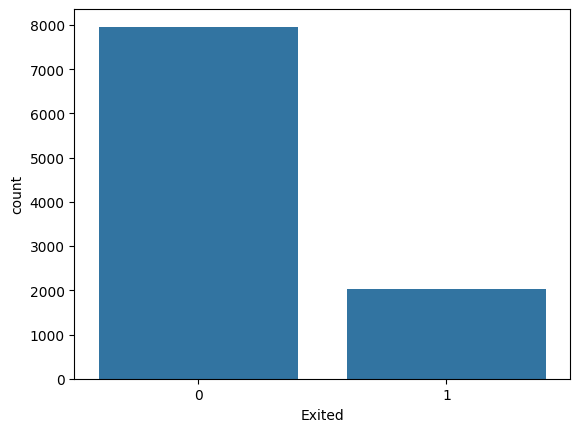

In [77]:
sns.countplot(data=data, x='Exited');

Посмотрим на то, сколько у нас иных признаков.

In [272]:
types = data.dtypes
num_features = list(types[(types != 'object')].index)
num_features

['CustomerId',
 'CreditScore',
 'Age',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'HasCrCard',
 'IsActiveMember',
 'EstimatedSalary',
 'Exited']

Посмотрим на их распределение.

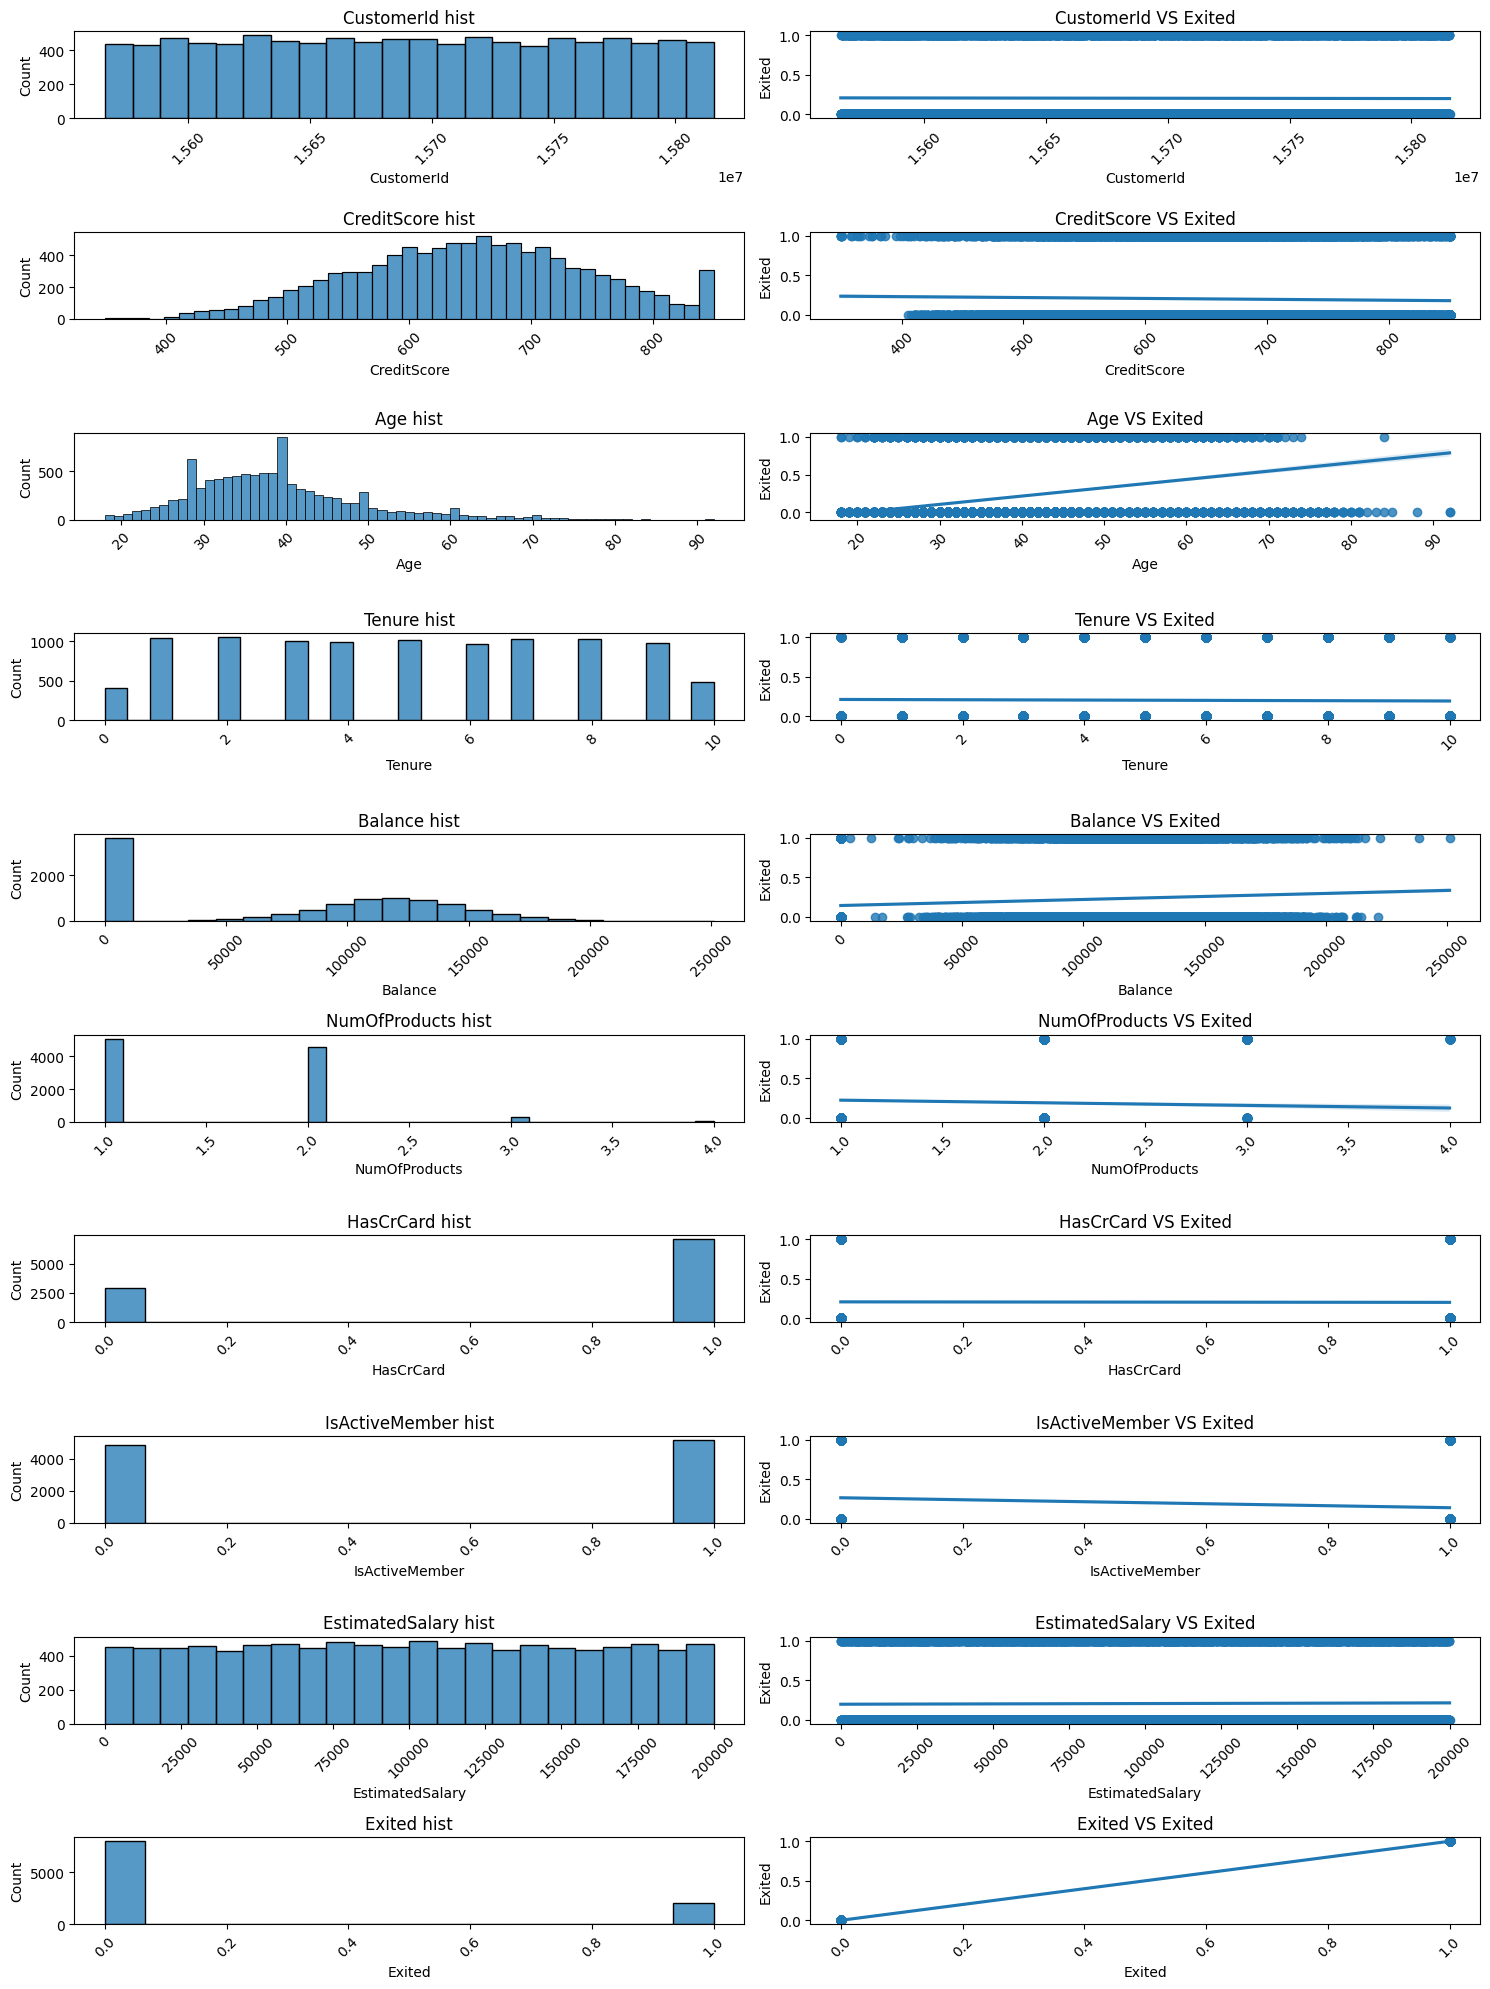

In [273]:
n = len(num_features) #количество числовых признаков
fig, axes = plt.subplots(n, 2, figsize=(15, 20)) # фигура + n х 2 координатных плоскостей
#Создаем цикл для всех признаков из списка числовых признаков
for i, feature in enumerate(num_features): #i- индекс, feature - название признака в таблице
    #Строим гистограмму распределения признака 
    histplot = sns.histplot(data=data, x=feature, ax=axes[i][0])
    #Добавляем подпись графику
    histplot.set_title('{} hist'.format(feature))
    #Добавляем поворот отметок на оси абсцисс
    histplot.xaxis.set_tick_params(rotation=45)
    #Строим диаграмму рассеяния + линейную регрессию
    regplot = sns.regplot(data=data, x=feature, y='Exited', ax=axes[i][1])
    #Добавляем подпись графику
    regplot.set_title('{} VS Exited'.format(feature));
    #Добавляем поворот отметок на оси абсцисс
    regplot.xaxis.set_tick_params(rotation=45)
plt.tight_layout() #выравнивание графиков

In [24]:
data.shape

(10000, 13)

Преобразуем признак пол.

In [78]:
data['Gender'] = data['Gender'].apply(lambda x: 0 if x == 'Female' else 1)

Что насчет территориального признака? Закодируем его.

In [79]:
data['Geography'].value_counts()

Geography
France     5014
Germany    2509
Spain      2477
Name: count, dtype: int64

In [80]:
data = pd.get_dummies(data, columns=['Geography'])

Кредитный рейтинг пусть тоже будет обобщен.

In [81]:
def get_credit_score_cat(credit_score):
    if credit_score >= 300 and credit_score < 500:
        return 1
    elif credit_score >= 500 and credit_score < 601:
        return 2
    elif credit_score >= 601 and credit_score < 661:
        return 3
    elif credit_score >= 661 and credit_score < 781:
        return 4
    elif credit_score >= 781 and credit_score < 851:
        return 5
    elif credit_score >= 851:
        return 6
    elif credit_score < 300:
        return 7

In [82]:
data['CreditScoreCat']= data['CreditScore'].apply(get_credit_score_cat)

Итак у нас есть следующие колонки.

In [83]:
types = data.dtypes
num_features = list(types[(types != 'object')].index)
num_features

['CustomerId',
 'CreditScore',
 'Gender',
 'Age',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'HasCrCard',
 'IsActiveMember',
 'EstimatedSalary',
 'Exited',
 'Geography_France',
 'Geography_Germany',
 'Geography_Spain',
 'CreditScoreCat']

In [84]:
cols_df = [x for x in data.columns if data[x].dtype == 'object']

# Удаляем колонки с типом 'object'
data1 = data.drop(columns=cols_df)


In [85]:
data1 = data1.drop(columns='CreditScore')
data1 = data1.drop(columns = 'CustomerId')
data1 = data1.drop(columns = 'EstimatedSalary')


В рамках избавления от выбросов, почистим немного датасет. Эти выбросы находила 

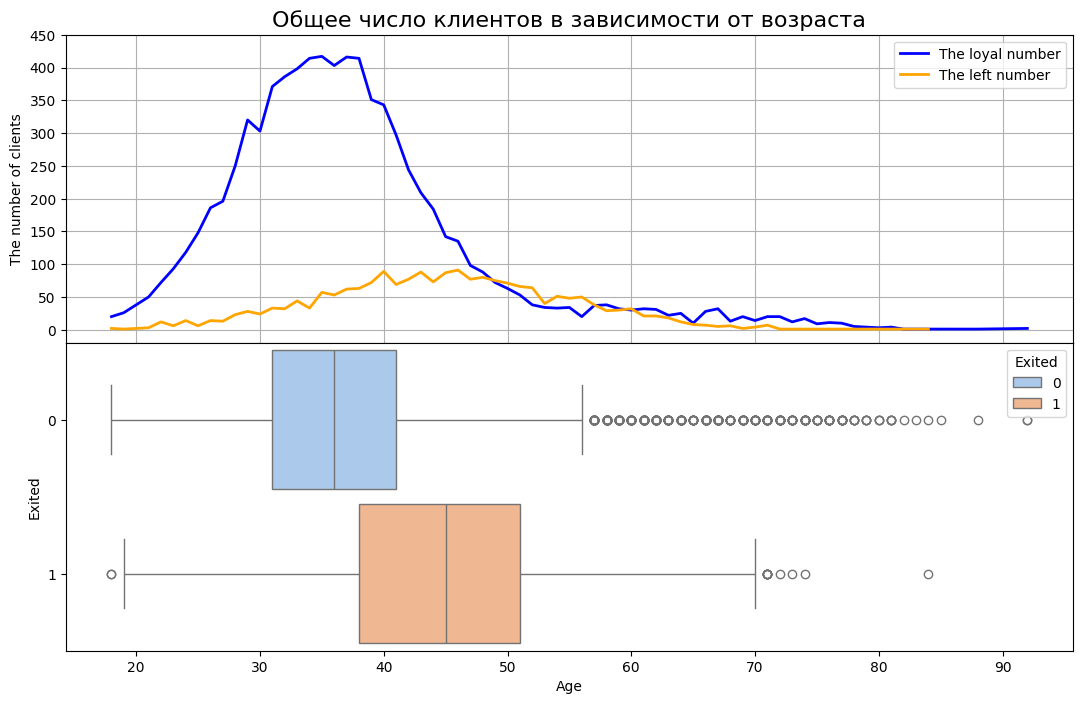

In [64]:
age_data_1 = data1[data1['Exited'] == 1]
age_grouped_1 = age_data_1.groupby(['Age'])[['Exited']].sum()
age_data_0 = data1[data1['Exited'] == 0]
age_grouped_0 = age_data_0.groupby(['Age'])[['Exited']].count()

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(13, 8))
plt.subplots_adjust(hspace=.0)
axes[0].plot(age_grouped_0['Exited'], label='The loyal number', c='blue', lw=2)
axes[0].plot(age_grouped_1['Exited'], label='The left number', c= 'orange', lw=2)


#установка параметров отображения
axes[0].set_title('Общее число клиентов в зависимости от возраста', fontsize=16)
axes[0].set_xlabel('Age')
axes[0].set_ylabel('The number of clients')
axes[0].set_yticks(range(0, 500, 50))
axes[0].xaxis.set_tick_params(rotation=10)
axes[0].grid()
axes[0].legend();

#sn.lineplot(x="Year", y="User Rating", data=data) 

boxplot = sns.boxplot(
    data=data1,
    x='Age',
    y='Exited',
    hue = 'Exited',
    orient='h',
    width=0.9,
    palette='pastel',
    ax=axes[1]
)

Потенциальные вбросы вероятны у ушедших в возрасте 70 лет. А также у оставшихся в возрасте от 55 лет. Уберем эти моменты. То же касается выбросов в балансе.

In [86]:
data1 = data1[~(((data1['Age'] > 70) & (data1['Exited'] == 1)) | ((data1['Age'] > 55) & (data1['Exited'] == 0)))]
data1 = data1[~(data1['Balance'] < 2500)]


На теповой карте мультиколлинеарности не обнаружено.

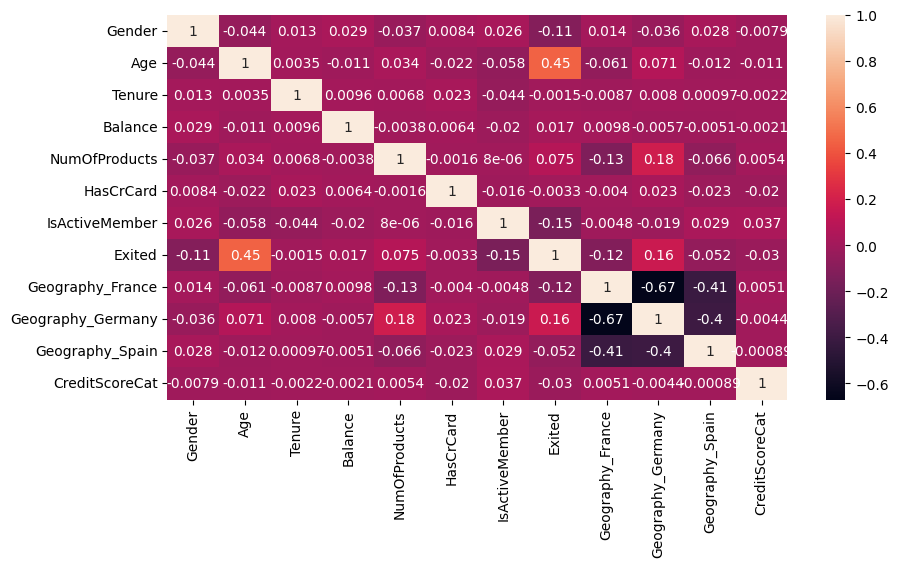

In [87]:
plt.figure(figsize = (10, 5))
sns.heatmap(data1.corr(), annot = True);

## Задача логистической регрессии

Разделим выборки

In [88]:
features = data1.drop('Exited', axis=1).columns
X, y = data1[features], data1['Exited']

In [89]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 1, test_size = 0.2)

Нормализация данных, тк модель плохо работает с ненормализованными данными.

In [90]:
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [91]:
from sklearn import linear_model #линейные модели

In [92]:
#Создаем объект класса логистическая регрессия
log_reg = linear_model.LogisticRegression(
    solver='sag', #алгоритм оптимизации
    random_state=1, #генератор случайных чисел
    max_iter=1000 #количество итераций на сходимость
)
#Обучаем модель, минимизируя logloss
log_reg.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000, random_state=1, solver='sag')

In [93]:
#Делаем предсказание для тренировочной выборки
y_train_pred = log_reg.predict(X_train_scaled)
#Вывод отчет о метриках классификации
print(metrics.classification_report(y_train, y_train_pred))
#Делаем предсказание для тестовой выборки
y_test_pred = log_reg.predict(X_test_scaled)
#Вывод отчет о метриках классификации
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.83      0.95      0.88      3635
           1       0.73      0.42      0.53      1223

    accuracy                           0.81      4858
   macro avg       0.78      0.68      0.71      4858
weighted avg       0.80      0.81      0.80      4858

              precision    recall  f1-score   support

           0       0.83      0.95      0.89       909
           1       0.74      0.44      0.55       306

    accuracy                           0.82      1215
   macro avg       0.79      0.69      0.72      1215
weighted avg       0.81      0.82      0.80      1215



Найдем пересечение метрик чтобы найти нужный порог вероятности.

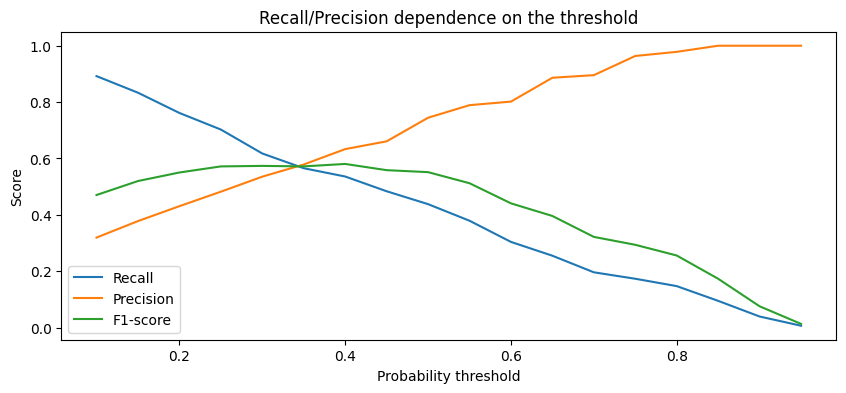

In [94]:
#Нас интересует только вероятность класса (второй столбец)
y_test_proba_pred = log_reg.predict_proba(X_test_scaled)[:, 1]
#Для удобства завернем numpy-массив в pandas Series
y_test_proba_pred = pd.Series(y_test_proba_pred)
#Создадим списки, в которых будем хранить значения метрик 
recall_scores = []
precision_scores = []
f1_scores = []
#Сгенерируем набор вероятностных порогов в диапазоне от 0.1 до 1
thresholds = np.arange(0.1, 1, 0.05)
#В цикле будем перебирать сгенерированные пороги
for threshold in thresholds:
    #В противном случае - к классу 0
    y_test_pred = y_test_proba_pred.apply(lambda x: 1 if x>threshold else 0)
    #Считаем метрики и добавляем их в списки
    recall_scores.append(metrics.recall_score(y_test, y_test_pred))
    precision_scores.append(metrics.precision_score(y_test, y_test_pred))
    f1_scores.append(metrics.f1_score(y_test, y_test_pred))

#Визуализируем метрики при различных threshold
fig, ax = plt.subplots(figsize=(10, 4)) #фигура + координатная плоскость
#Строим линейный график зависимости recall от threshold
ax.plot(thresholds, recall_scores, label='Recall')
#Строим линейный график зависимости precision от threshold
ax.plot(thresholds, precision_scores, label='Precision')

#Строим линейный график зависимости F1 от threshold
ax.plot(thresholds, f1_scores, label='F1-score')
#Даем графику название и подписи осям
ax.set_title('Recall/Precision dependence on the threshold')
ax.set_xlabel('Probability threshold')
ax.set_ylabel('Score')
ax.legend();

In [95]:
#Задаем оптимальный порог вероятностей
threshold_opt = 0.36
#Людей, у которых вероятность зарабатывать >50K больше 0.4 относим к классу 1
#В противном случае - к классу 0
y_test_pred_opt = y_test_proba_pred.apply(lambda x: 1 if x > threshold_opt else 0)
#Считаем метрики
print(metrics.classification_report(y_test, y_test_pred_opt))

              precision    recall  f1-score   support

           0       0.85      0.87      0.86       909
           1       0.59      0.56      0.57       306

    accuracy                           0.79      1215
   macro avg       0.72      0.71      0.72      1215
weighted avg       0.79      0.79      0.79      1215



Метрики улучшились.

**Что можно увидеть в результате? Во-первых 0 мы угадываем существенно лучше, чем единицы. Во-вторых, accurancy смотреть не нужно, тк данные несбалансированы. Выбор метрики зависит от формулировки задачи.**


Ранее мы построили модель логистической регрессии, затем добавили в неё полиномиальные признаки и подобрали оптимальный порог вероятности для логистической регрессии.

Теперь попробуем решить задачу с помощью деревьев решений и случайных лесов.

Примечание. Для выполнения дальнейших заданий необходимо совершить уже знакомые вам шаги предобработки с данными об оттоке клиентов банка, а именно:

-выделить данные, относящиеся к отделениям банка в Германии;
-избавиться от заведомо неинформативных признаков;
-расширить датасет путём добавления новых признаков;
-разделить выборку на тренировочную и тестовую со стратификацией.

In [17]:
data1.head()

,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,Exited,Geography_France,Geography_Germany,Geography_Spain,CreditScoreCat
1,1,41,1,83807.86,1,0,1,0,False,False,True,3
2,1,42,8,159660.80,3,1,0,1,True,False,False,2
4,1,43,2,125510.82,1,1,1,0,False,False,True,5
5,1,44,8,113755.78,2,1,0,1,False,False,True,3
7,1,29,4,115046.74,4,1,0,1,False,True,False,1


**Подготовка датасета - в задании по деревьям сказано, что нужно брать только Германию.**

Ее и отфильтруем. И удалим ненужные колонки.

In [18]:
data1 = data1[~(data1['Geography_Germany'] == False)]

In [20]:
data1 = data1.drop(columns=['Geography_France','Geography_Germany','Geography_Spain'])

## Деревья решений #

Делим выборки

In [22]:
features = data1.drop('Exited', axis=1).columns
X, y = data1[features], data1['Exited']

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 1, test_size = 0.2)

Учим модель

In [24]:
from sklearn import tree #модели деревьев решения

In [30]:
#Создаём объект класса DecisionTreeClassifier
dt_clf_full = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий эффективности
    max_depth=6, #максимальная глубина дерева
    random_state=42 #генератор случайных чисел
)
#Обучаем модель по алгоритму CART
dt_clf_full.fit(X, y)

#Делаем предсказание класса
y_pred = dt_clf_full.predict(X)
#Выводим отчёт о метриках
print(metrics.classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.94      0.88      1595
           1       0.83      0.60      0.70       810

    accuracy                           0.82      2405
   macro avg       0.83      0.77      0.79      2405
weighted avg       0.83      0.82      0.82      2405



In [26]:
print(dt_clf_full.feature_importances_)

[0.         0.52245253 0.01266657 0.12255077 0.32445818 0.
 0.01384493 0.00402703]


Смотрим значимые признаки.

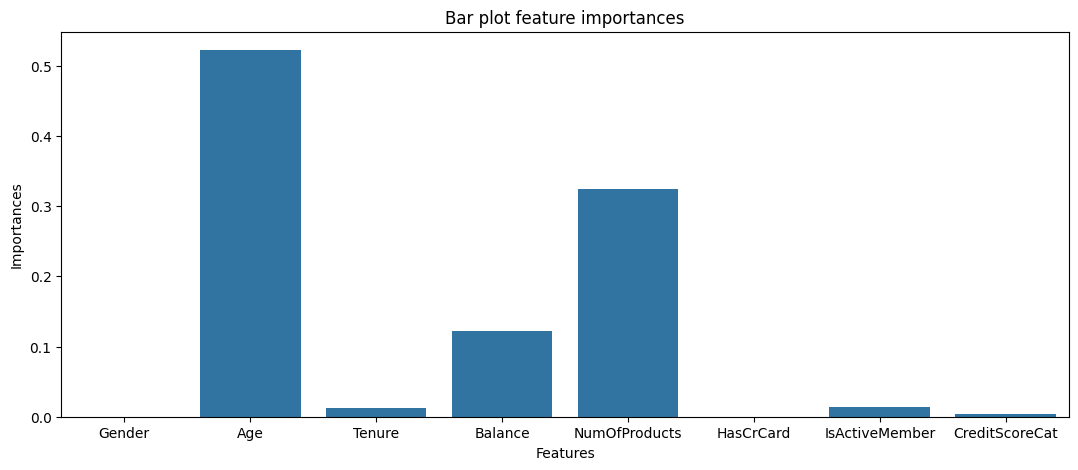

In [27]:
fig, ax = plt.subplots(figsize=(13, 5)) #фигура + координатная плоскость
feature = X.columns #признаки
feature_importances = dt_clf_full.feature_importances_ #важность признаков
#Строим столбчатую диаграмму
sns.barplot(x=feature, y=feature_importances, ax=ax);
#Добавляем подпись графику, осям абсцисс и ординат
ax.set_title('Bar plot feature importances')
ax.set_xlabel('Features')
ax.set_ylabel('Importances');

## Случайный лес

In [31]:
rf_clf_full = ensemble.RandomForestClassifier(
    n_estimators=300, #число деревьев
    criterion='entropy', #критерий эффективности
    max_depth=6, #максимальная глубина дерева
    max_features='sqrt', #число признаков из метода случайных подространств
    random_state=42 #генератор случайных чисел
)
#Обучаем модель 
rf_clf_full.fit(X, y)

#Делаем предсказание класса
y_pred = rf_clf_full.predict(X)
#Выводим отчёт о метриках
print(metrics.classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.94      0.88      1595
           1       0.85      0.62      0.72       810

    accuracy                           0.84      2405
   macro avg       0.84      0.78      0.80      2405
weighted avg       0.84      0.84      0.83      2405



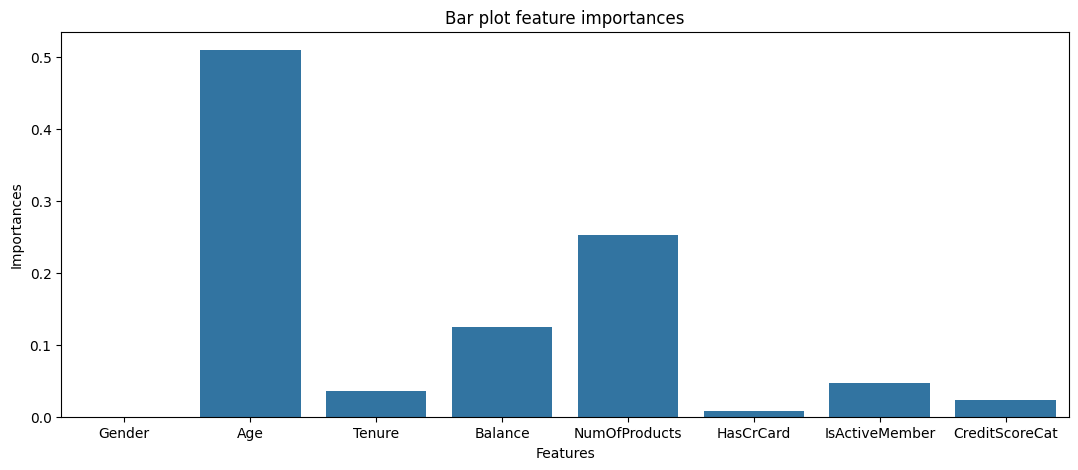

In [32]:
fig, ax = plt.subplots(figsize=(13, 5)) #фигура + координатная плоскость
feature = X.columns #признаки
feature_importances = rf_clf_full.feature_importances_ #важность признаков
#Строим столбчатую диаграмму
sns.barplot(x=feature, y=feature_importances, ax=ax);
#Добавляем подпись графику, осям абцисс и ординат
ax.set_title('Bar plot feature importances')
ax.set_xlabel('Features')
ax.set_ylabel('Importances');

**Диаграммы значимости для леса и дерева различаются. Так, например, лес считает признаки Tenure и CreditScore  более значимыми признаками, чем предыдущая модель. С учетом самой логики голосования это вполне естественно . Лучшие метрики вывел, что естественно, случайный лес. Но в нашем случае данное отличие несущественно. Думаю это связано с тем, что признаков тут не самое большое число получилось** 